## Import Libraries

In [2]:
import os
from os.path import exists
os.environ['OMP_NUM_THREADS'] = '1'
import glob
import sys
sys.path.append(os.path.join(os.getcwd(), *tuple(['..'])))
import argparse
import glob
import json
import pdb
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt
import argparse
import pyfiglet
from skimage import measure
from tqdm import tqdm
from PIL import Image
import pyvips as Vips
from torchvision import transforms
import torchvision
import cv2
from shapely.geometry import Polygon
from shapely import box as shapely_box
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_recall_fscore_support
from models_pytorch_lightning.model_mrcnn_config import _default_mrcnn_config, build_default
from features import build_features
from models_pytorch_lightning.generalized_mask_rcnn_pl import LitMaskRCNN
from features import transforms as T
import torch

## Loading trained Mask RCNN model

In [3]:
class_names = ["Cored","Diffuse","Coarse-Grained","CAA"] # define classes
test_config = dict(batch_size = 1,num_classes=4, device_id =0) # config
model_name= "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/yp2mf3i8_epoch=108-step=872.ckpt"
model_config = _default_mrcnn_config(num_classes=1 + test_config['num_classes']).config
model = LitMaskRCNN.load_from_checkpoint(model_name)

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'rpn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rpn'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'roi_heads' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['roi_heads'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/u

In [4]:
device = torch.device('cuda', test_config['device_id'])
model = model.to(device)
model.eval()

LitMaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256,

## Helper functions

In [5]:
ID_MASK_SHAPE = (1024, 1024)

# Color Coding
lablel2id = {'Cored':'50', 'Diffuse':'100',
             'Coarse-Grained':'150', 'CAA': '200', 'Unknown':'0'}

DATASET_PATH = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data"

In [6]:
def save_img(img, file_name, tileX, tileY, label="mask"):
    """
    Saves an image to a specified directory, creating necessary subdirectories if they don't exist.
    
    The image is saved with a filename that includes the tile coordinates (tileX, tileY) and the provided label 
    (default is "mask"). The function ensures that a directory structure is created for the dataset and label 
    (e.g., "mask" or other labels) before saving the image.

    Args:
        img (numpy.ndarray): The image to be saved, in the form of a NumPy array.
        file_name (str): The base name of the file (excluding extension) used to create the folder and file name.
        tileX (int): The x-coordinate of the tile, which will be included in the saved filename.
        tileY (int): The y-coordinate of the tile, which will be included in the saved filename.
        label (str, optional): The label to categorize the image (e.g., "mask"). Default is "mask".
    
    Returns:
        None: This function does not return any value. It performs a side effect of saving the image.
    """
    # Convert the NumPy array to an Image object
    im = Image.fromarray(img)

    base_name_with_ext = os.path.basename(file_name)

    # Remove the extension to get the folder name
    folder_name = os.path.splitext(base_name_with_ext)[0]

    folder_name = os.path.join(DATASET_PATH, folder_name)

    # Create the new folder only if it does not exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Mask Folder
    save_dir = os.path.join(folder_name, label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = file_name + "_" + str(tileX) + "x" + "_" + str(tileY) + "y" + "_" + label + ".png"
    # Save the image to the specified directory
    save_name = os.path.join(save_dir, file_name)
    im.save(save_name)

In [7]:
def polygon2id(image_shape, mask, ids, coords_x, coords_y):
    """
    Converts polygon coordinates into an ID mask by filling the polygon area with the provided ID.

    This function uses the `draw.polygon` function from the `skimage` library to draw a polygon on the mask. 
    The polygon's coordinates are provided as `coords_x` and `coords_y`, and the mask is filled with the given 
    ID at the corresponding positions.

    Args:
        image_shape (tuple): The shape of the image (height, width) to define the mask size.
        mask (numpy.ndarray): The mask array to be updated with the polygon ID. The mask should have the same 
                              shape as the image.
        ids (int): The ID to assign to the pixels inside the polygon.
        coords_x (list or numpy.ndarray): The x-coordinates of the polygon's vertices.
        coords_y (list or numpy.ndarray): The y-coordinates of the polygon's vertices.
    
    Returns:
        numpy.ndarray: The updated mask with the polygon area filled with the given ID.
    """
    vertex_row_coords, vertex_col_coords = coords_y, coords_x
    fill_row_coords, fill_col_coords = draw.polygon(
        vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = ids
    return mask

def polygon2mask1(image_shape, mask, color, coords_x, coords_y):
    """Compute a mask with labels having different colors
    from polygon.
    Parameters
    ----------
    image_shape : tuple of size 2.
        The shape of the mask.
    coords_x: X coordinates
    coords_y: Y coordinates
    mask : Mask with same size of the image (initially empty
    mask is given as input)
    Returns
    -------
    mask : 2-D ndarray of type 'bool'.
        The mask that corresponds to the input polygon.
    """

    vertex_row_coords, vertex_col_coords = coords_x, coords_y
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = color

    # mask[fill_row_coords, fill_col_coords] = color
    return mask

def get_vips_info(vips_img):
    # # Get bounds-x and bounds-y offset
    vfields = [f.split('.') for f in vips_img.get_fields()]
    vfields = [f for f in vfields if f[0] == 'openslide']
    vfields = dict([('.'.join(k[1:]), vips_img.get('.'.join(k))) for k in vfields])
    return vfields

In [8]:
def prepare_input(image):
    """
    Prepares an image for model input by normalizing and transforming it into a tensor.

    Args:
        image (PIL.Image or numpy.ndarray): The input image to be processed.

    Returns:
        tuple: A tuple containing:
            - input_tensor (torch.Tensor): The processed image tensor ready for model input.
            - image_float_np (numpy.ndarray): The normalized image as a float32 numpy array.
    """
    image_float_np = np.float32(image) / 255
    # define the torchvision image transforms
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #transforms.Normalize([0.8883, 0.8769, 0.8431],[0.1425, 0.1589, 0.2029])
    ])
    input_tensor = transform(image)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_tensor = input_tensor.to(device)
    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor, image_float_np

In [9]:
def get_output(outputs, threshold ):
    """
    Extracts and filters the predicted boxes, class IDs, scores, and masks from model outputs.

    Args:
        outputs (list): The model's output, typically from a detection model, containing boxes, labels, scores, and masks.
        threshold (float): The score threshold to filter predictions.

    Returns:
        tuple: A tuple containing:
            - pred_scores (numpy.ndarray): The filtered prediction scores.
            - pred_class_ids (numpy.ndarray): The filtered predicted class IDs.
            - pred_masks (numpy.ndarray): The filtered predicted masks.
            - pred_boxes (numpy.ndarray): The filtered predicted bounding boxes.
    """
    i =0 
    pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
    pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
    pred_scores = outputs[i]["scores"].cpu().detach().numpy()
    pred_masks = outputs[i]["masks"][pred_scores>=threshold]
    pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
    pred_masks = pred_masks.cpu().detach().numpy()
    pred_boxes =pred_boxes[pred_scores>=threshold]
    pred_class_ids = pred_class_ids[pred_scores>=threshold]
    pred_scores = pred_scores[pred_scores>=threshold]
    return pred_scores,pred_class_ids,pred_masks,pred_boxes

In [10]:
def draw_boxes(boxes, image,gt_class, pred_class, rater_name):
    """
    Draws a bounding box on the image with ground truth and predicted class labels.

    Args:
        boxes (tuple): Coordinates of the bounding box (x1, y1, x2, y2).
        image (numpy.ndarray): The image on which to draw the bounding box.
        gt_class (str): The ground truth class label.
        pred_class (str): The predicted class label.
        rater_name (str): The name of the rater.

    Returns:
        numpy.ndarray: The image with the drawn bounding box and class labels.
    """
    cv2.rectangle(
        image,
        (int(boxes[0]), int(boxes[1])),
        (int(boxes[2]), int(boxes[3])),
        (0,0,0), 2
    )
    cv2.putText(image , "gt:"+gt_class+"_"+"pred:"+pred_class+"_"+rater_name, (int(boxes[0]), int(boxes[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    return image
    

In [11]:
def get_match(img, json_file_name, threshold =0.5):
    """
    Process an image and its corresponding JSON annotations to compare ground truth labels with predicted labels.
    
    Args:
        img (str): Path to the input image file.
        json_file_name (str): Path to the JSON file containing annotations for the image.
        threshold (float, optional): Threshold for classification score to consider as a match (default is 0.5).
        
    Returns:
        tuple: A tuple containing actual labels, raters, predicted labels, and object names.
    """
    vips_img = Vips.Image.new_from_file(img, level=0)
    vinfo = get_vips_info(vips_img)

    # Get the corresponding json file
    json_file_name = os.path.basename(img).split(".mrxs")[0] + ".json"
    json_file_name = os.path.join(json_path, json_file_name)

    # Load JSON data
    with open(json_file_name) as f:
        data = json.load(f)
        
    # Initialize lists for storing results
    actual_labels= []   
    raters = []
    pred_labels = []
    object_names = []
    k=0
    
    for tileId, ele in data.items():
        # print("****************", tileId)
        tileId = tileId.replace("[", "")
        tileId = tileId.replace("]", "")
        tileX = int(tileId.split(",")[0])
        tileY = int(tileId.split(",")[1])
        
        tileWidth = 1024
        tileHeight = 1024

        # Calculate tile coordinates
        tileX = (tileX * tileWidth) + int(vinfo['bounds-x'])
        tileY = (tileY * tileHeight) + int(vinfo['bounds-y'])
        
        # Crop the image to the tile's coordinates    
        vips_img_crop = vips_img.crop(tileX, tileY, tileWidth, tileHeight)
        vips_img_crop = np.ndarray(buffer=vips_img_crop.write_to_memory(), dtype=np.uint8,
                                    shape=(vips_img_crop.height, vips_img_crop.width, vips_img_crop.bands))[..., :3]

        # Adjust tile boundaries for prediction
        x1 = tileX - int(vinfo['bounds-x'])
        x2 = tileX + tileWidth - int(vinfo['bounds-x'])
        y1 = tileY - int(vinfo['bounds-y'])
        y2 = tileY + tileHeight - int(vinfo['bounds-y'])
        
        # Prepare image input and get predictions
        input_tensor, image_float_np = prepare_input(vips_img_crop)
        outputs = model.forward(input_tensor)
        pred_scores,pred_class_ids,pred_masks,pred_boxes=get_output(outputs,0.75)

        # Convert predicted boxes to polygon coordinates
        pred_boxes_cnt =  [np.int32(np.array([[box[0],box[1]],[box[0],box[3]],[box[2],box[3]],[box[2],box[1]]])) for box in pred_boxes]
        
        # Compare ground truth annotations with predicted boxes
        for region in ele:
            if 'label' in region.keys() and 'name' in region['label'].keys():
                x_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][0]
                y_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][1]
                region_points = region["region_attributes"][0]["points"]
                region_points = [ [p[0]-x_bound, p[1]-y_bound] for p in region_points]
                mean_reg = np.mean(region_points, axis=0)
                for i, box in enumerate(pred_boxes_cnt):
                    if len(region_points)<4:
                        print(region_points)
                    if len(region_points)>=4:
                        polygon1 = Polygon(np.array(region_points,dtype=np.int32))
                        polygon2 = Polygon(box)
                            # Check for intersection
                        if polygon1.intersects(polygon2): # check match based on polygon intersection
                            actual_labels.append(region['label']['name'])
                            raters.append(region["raterName"])
                            pred_labels.append(class_names[pred_class_ids[i]-1])
                            if "object_name" in region.keys():
                                object_names.append(region["object_name"])
                            else:
                                object_names.append(None)
                        
                            if region['label']['name']!=class_names[pred_class_ids[i]-1]:
                                k=k+1
                                vips_img_crop1=vips_img_crop.copy()
                                vips_img_crop1 = np.ascontiguousarray(vips_img_crop1, dtype=np.uint8)
                                image = draw_boxes(pred_boxes[i], vips_img_crop1, region['label']['name'], class_names[pred_class_ids[i]-1], region["raterName"])
                                image1 = Image.fromarray(image)
                                image1.save("/home/mahirwar/Desktop/Monika/npsad_data/vivek/model_analysis/test-interrater/"+json_file_name.split("/")[-1]+str(tileId)+"_"+str(k)+".png")
    return actual_labels,raters,pred_labels,object_names


## Load all raters annotations and match pred label with GT

In [12]:
#json_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/test_jsons_all"
json_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/test_json_harry_max_brittany_osama"
json_files = glob.glob(os.path.join(json_path,"*"))
json_files = [x.split("/")[-1] for x in json_files]
imgs = [os.path.join(DATASET_PATH,x.replace(".json",".mrxs")) for x in json_files]

In [26]:
## generated previously
all_objects = pd.read_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/interrater_oct24/all_objects_full.csv") 

In [15]:
# get match for all json files and images for all raters
actual_labels_all= []
raters_all = []
pred_labels_all = []
object_name_all= []
imgs_all = []

for img, json_file_name in zip(imgs,json_files):
    actual_labels,raters,pred_labels, object_names= get_match(img, json_file_name,0.73)
    actual_labels_all.extend(actual_labels)
    raters_all.extend(raters)
    pred_labels_all.extend(pred_labels)
    object_name_all.extend(object_names)
    imgs_all.extend([img.split("/")[-1]]*len(actual_labels))
    
# create a complete dataframe of all pred, actual labels, rater names, object and image names 
df = pd.DataFrame({"pred_labels":pred_labels_all,"actual_label":actual_labels_all, "rater_name":raters_all,"object_names":object_name_all,"img_name":imgs_all})

In [20]:
df["rater_name"].unique()

array(['Max', 'Harry', 'Brittany', 'Osama'], dtype=object)

In [21]:
len(df)

460

## Get label wise consensus

In [30]:
def get_consensus(l, column_class):
    """
    Computes a consensus score by evaluating the uniqueness of the classes 
    in the specified columns of a list.

    Args:
        l (list): A list of lists or objects from which classes are extracted.
        column_class (list): A list of column indices or keys specifying which elements in `l` to evaluate.

    Returns:
        int: The consensus score, which is the difference between the length of the class list 
             and the number of unique classes, incremented by 1.
    """
    # Extract classes from the specified columns in the list 'l'
    clss = [l[x] for x in column_class]
    
    # Filter out any entries that are 'None' or 'None' as strings
    clss = [x for x in clss if x != "None" and x is not None]
    
    # Return the consensus score: len(classes) + 1 - unique classes count
    return len(clss) + 1 - len(np.unique(clss))

In [31]:
def map_consensus_class(l, class_name, column_class):
    """
    Maps a consensus class value based on the occurrence of a specified class in the list.
    
    Args:
        l (list): A list or dictionary containing data to be evaluated.
        class_name (str): The class name to be checked in the specified columns.
        column_class (list): A list of column indices or keys specifying which elements in `l` to evaluate.
        
    Returns:
        int: Returns 1 if the consensus value matches the number of occurrences of `class_name`, otherwise 0.
    """
    # Extract the specified classes from the list 'l'
    clss = [l[x] for x in column_class]
    
    # Filter the classes that match the specified 'class_name'
    clss = [x for x in clss if x == class_name]
    
    # Compare the consensus value with the count of the specified class
    if l["consensus"] == len(clss):
        return 1
    
    # Return 0 if they don't match
    return 0

In [29]:
# columns to use for matching labels
column_class =  [x+"_class" for x in df["rater_name"].unique()]
column_class

['Max_class', 'Harry_class', 'Brittany_class', 'Osama_class']

In [39]:
# get consensus of objects across raters
all_objects["consensus"] = all_objects.apply(lambda l: get_consensus(l, column_class), axis=1)
all_objects["consensus"].value_counts()

3    233
2     70
4     51
1      5
Name: consensus, dtype: int64

In [40]:
# create class wise consensus for all objects
all_objects["Cored_consensus"] = all_objects.apply(lambda l: map_consensus_class(l,"Cored", column_class), axis=1)
all_objects["Coarse_grained_consensus"] =all_objects.apply(lambda l: map_consensus_class(l,"Coarse-Grained", column_class), axis=1)
all_objects["Diffuse_consensus"] =all_objects.apply(lambda l: map_consensus_class(l,"Diffuse", column_class), axis=1)

### Core class consensus

In [78]:
# Consenus values are 1,2,3,4. 4 means all agree, 3 means 3 of them agree ; with their ratios for Cored class
all_objects[all_objects["Cored_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Cored_consensus"]==1])

3    0.461538
4    0.282051
2    0.128205
1    0.128205
Name: consensus, dtype: float64

In [81]:
len(all_objects[all_objects["Cored_consensus"]==1])

39

### Diffuse class consensus

In [79]:
# Consenus values are 1,2,3,4. 4 means all agree, 3 means 3 of them agree ; with their ratios for Diffuse Class
all_objects[all_objects["Diffuse_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Diffuse_consensus"]==1])

3    0.448718
4    0.333333
2    0.153846
1    0.064103
Name: consensus, dtype: float64

In [82]:
len(all_objects[all_objects["Diffuse_consensus"]==1])

78

### Coarse-Grained class consensus

In [80]:
# Consenus values are 1,2,3,4. 4 means all agree, 3 means 3 of them agree ; with their ratios for Coarse Grained class
all_objects[all_objects["Coarse_grained_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Coarse_grained_consensus"]==1])

2    0.510204
3    0.244898
4    0.163265
1    0.081633
Name: consensus, dtype: float64

In [84]:
len(all_objects[all_objects["Coarse_grained_consensus"]==1])

49

In [85]:
# save consensus dataset
all_objects.to_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/interrater_oct24/all_objects_consensus.csv")

In [45]:
all_objects.groupby(["Max_class","Harry_class","Cored_consensus"])["Cored_consensus"].count()

Max_class       Harry_class     Cored_consensus
Coarse-Grained  Coarse-Grained  0                  60
                Cored           1                   3
                Diffuse         0                  22
                Neuritic        0                   2
                None            0                  16
                                1                   1
Cored           Coarse-Grained  0                   8
                                1                   7
                Cored           0                   5
                                1                  26
                Diffuse         0                   5
                Neuritic        0                   1
                                1                   1
                None            0                   4
                                1                   1
Diffuse         Coarse-Grained  0                  14
                Diffuse         0                  71
                None            0 

In [93]:
## >=3 is used - majority of pathologists agrees
consensus_objects = all_objects[all_objects["consensus"]>=3]

## Compute model performance metric wrt NP

In [96]:
## create flag if any of the objects are in consensus>=3
df["flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max" and l["object_names"] in consensus_objects["Max_object_name"].values) or  
                      (l["rater_name"]=="Brittany" and l["object_names"] in consensus_objects["Brittany_object_name"].values) or  
                      (l["rater_name"]=="Harry" and l["object_names"] in consensus_objects["Harry_object_name"].values) or  
                      (l["rater_name"]=="Osama" and l["object_names"] in consensus_objects["Osama_object_name"].values) else 0, axis=1)

In [280]:
# not used
df["actual_label1"] =  np.where(df["actual_label"]=="Neuritic","Coarse-Grained",df["actual_label"]) ## Neuritic should be counted as Coarse-Grained as per pathologist

In [276]:
df.head(2)

,pred_labels,actual_label,rater_name,object_names,img_name,flag,actual_label1
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs,0,Coarse-Grained


### Accuracy Values of each rater's annotations against model predictions

In [98]:
raters = df["rater_name"].unique()

In [99]:
# Compute accuracy of each rater's annotations against model predictions
for rater in raters:
    df_max= df[(df["rater_name"]==rater) ]
    print("Rater", rater)
    conf_mat = confusion_matrix(df_max["actual_label"],df_max["pred_labels"])
    print(conf_mat)
    print(np.trace(conf_mat)/np.sum(conf_mat))

Rater Max
[[ 0  0  0  0]
 [ 0 15  2 23]
 [ 1  8  7  9]
 [ 0  0  0 55]]
0.6416666666666667
Rater Harry
[[ 0  0  0  0  0]
 [ 0 22  2 24  0]
 [ 2  3  7  6  0]
 [ 0  1  0 83  0]
 [ 0  3  0  0  0]]
0.7320261437908496
Rater Brittany
[[ 0  0  0  0]
 [ 0  8  3  2]
 [ 2  4  5  3]
 [ 0  8  0 55]]
0.7555555555555555
Rater Osama
[[ 0  0  0  0]
 [ 0 12  4  2]
 [ 1  3  4  0]
 [ 0  7  1 63]]
0.8144329896907216


### Consensus accuracy - Taking consensus of all raters against model predictions

[[  0   0   0   0]
 [  0  47   9  37]
 [  6  16  20  16]
 [  0  14   1 253]]
0.7637231503579952


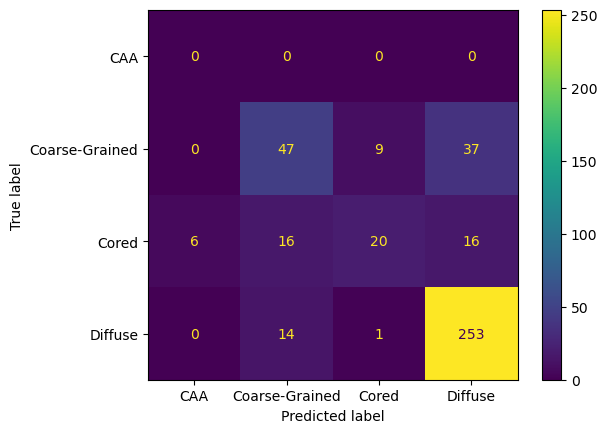

In [100]:
## get consensus accuracy (atleast 3of 4 raters agree) by setting flag as 1
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))

### Precision, Recall, F1-score values

[[  0   0   0   0]
 [  0  47   9  37]
 [  6  16  20  16]
 [  0  14   1 253]]
[0.         0.61038961 0.66666667 0.82679739] [0.         0.50537634 0.34482759 0.94402985] [0.         0.55294118 0.45454545 0.8815331 ] [  0  93  58 268]
0.7637231503579952


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


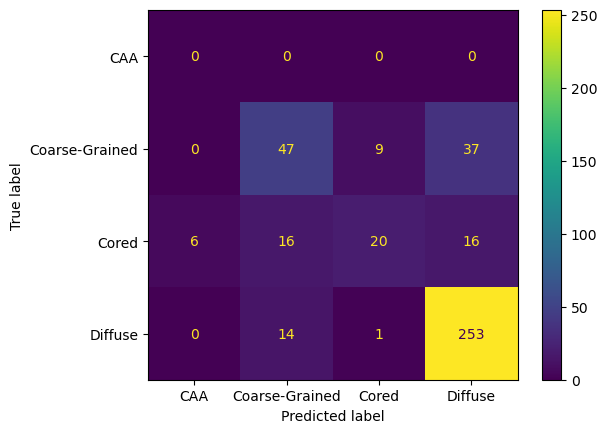

In [101]:
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])

precision, recall, fscore, support = precision_recall_fscore_support(df_common["actual_label"],df_common["pred_labels"])
print(precision, recall, fscore, support)
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))